### Описание проекта и цели.

#### Цели проекта постоить модель предсказания сердечного приступа у пациента.

Входные данные:
Предоставлены данные с парметрами и привычками зафиксированными в ходе опроса пациента.

Для выполнения цели получена информация с данными для работы:
1. heart_test.csv 
2. heart_train.csv

Описание исходных данных: <br>
– Данные пациентов для предсказания риска сердечных приступов<br>
– id<br>
– Антропометрические параметры (вес, возраст, рост)<br>
– Привычки (курение, качество сна и т.д)<br>
– Давление<br>
– Наличие хронических заболеваний<br>
– Биохимия крови<br>
– Таргет - высокий или низкий риск поражения сердца<br>


План выполнения проекта:
1. Исследовать датасет
2. Предобработать данные
3. Обучить модели
4. Подготовка предсказания на тестовой выборке

### Установка и ввод констант.

In [1]:
# установка библиотек
!python3 -m pip install seaborn -q
!python3 -m pip install phik -q
!python3 -m pip install joblib -q

In [2]:
# Импортируем библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import joblib


# загружаем модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
# импортируем класс RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# загружаем функцию для работы с метриками
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer

In [3]:
# константы 
RANDOM_STATE = 42
TEST_SIZE = 0.2

scaler = StandardScaler()
encoder = OneHotEncoder()
clf = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear',penalty=['l1','l2'])

In [4]:
# Ввод функций

# Функция создает для списка столбцов два графика - гистограмму и ящик с усами.
def todoplot(df):
    for i in col_1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

In [5]:
# Ввод функций

# Функция создает круговые диаграммы из списка столбцов
def todopie(df):
       for i in col_2:
              fig, ax = plt.subplots(figsize=(5,5))
              values = df[i].value_counts()
              ax.pie(values, 
                     labels=values.index,
                     autopct='%1.1f%%');
              ax.set_title(f'Процент расперделения значений в {i}')
              plt.show()

### Загрузка данных.

In [6]:
# Файлы heart_test.csv, heart_train.csv

pth1 = '/Users/georgekhokhlov/Cursor_project/YA_proj/Masterskaya/heart_train.csv'
pth2 = '/Users/georgekhokhlov/Cursor_project/YA_proj/Masterskaya/heart_test.csv'

if os.path.exists(pth1):
    heart_train = pd.read_csv(pth1)
    print(f'Файл heart_train.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth2):
    heart_test = pd.read_csv(pth2)
    print(f'Файл heart_test.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    


Файл heart_train.csv успешно загружен
Файл heart_test.csv успешно загружен


### Ознакомимся с данными

In [7]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [8]:
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

В таблицах явно есть пропуски, а также названия стобцов не приведены к единому стилю.

### Предобработка данных.

Ознакомимся с таблицей heart_train. Проведем необходимую предобработку данных.

In [9]:
# рассмотрим записи в таблице heart_train
heart_train.tail()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
8680,8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,...,0.0,0.166667,0.0,0.136364,0.006771,0.088261,Male,0.632258,0.511628,5734
8681,8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,...,6.0,0.833333,0.0,0.195652,0.008339,0.000777,Male,0.561290,0.511628,5191
8682,8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,...,1.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.374194,0.558140,5390
8683,8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,...,4.0,0.500000,0.0,0.227018,0.048229,0.036512,Male,0.477419,0.744186,860
8684,8684,0.292135,0.342857,0.021082,0.0,1.0,1.0,1.0,0.0,0.567079,...,5.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.703226,0.639535,7270


In [10]:
# Заменим регистр и символы в названиях
heart_train.columns = [col.
                       lower().replace(' ','_').
                       replace(':','').replace('(','').
                       replace(')','').replace('-','_') 
                       for col in heart_train.columns
]

In [11]:
# рассмотрим записи в таблице heart_train
heart_train.head()

,unnamed_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [12]:
# выполним проверку полных дубликатов
heart_train[heart_train.duplicated()]

,unnamed_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id


Полных дубликатов не найдено. А не явные дубликаты таким образов не выловить. Попробуем это сделать н следующем этапе.

In [13]:
# узнаем количество пропусков
heart_train.isna().sum()

unnamed_0                            0
age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk_binary             0
blood_sugar                          0
ck_mb                                0
troponin                             0
gender                               0
systolic_blood_pressure  

Пропуски имеют в девяти столбцах и только у 243 пациентов, вероятно, эти данные не собирали для них, либо они были утеряны. Также в таблице есть колонка дублирующая нумерацию строк – unnamed_0. Удалим ее.

In [14]:
heart_train = heart_train.iloc[:,1:]

Ознакомимся с таблицей heart_test. Проведем необходимую предобработку данных.

In [15]:
# рассмотрим записи в таблице heart_test
heart_test.tail()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
961,961,0.640449,0.235714,0.064161,1.0,0.0,1.0,0.0,1.0,0.449213,...,0.283117,5.0,0.000000,0.110672,0.049750,0.000777,Male,0.425806,0.744186,9271
962,962,0.516854,0.367857,0.063245,1.0,0.0,1.0,0.0,0.0,0.563595,...,0.422078,2.0,0.000000,0.114625,0.008706,0.001456,Male,0.651613,0.697674,8012
963,963,0.213483,0.596429,0.076994,1.0,0.0,1.0,1.0,1.0,0.549976,...,0.914286,4.0,0.666667,0.227018,0.048229,0.036512,Male,0.696774,0.767442,2456
964,964,0.337079,0.996429,0.036664,1.0,0.0,1.0,0.0,0.0,0.441581,...,0.850649,2.0,0.500000,0.132411,0.006904,0.000485,Male,0.348387,0.627907,4984
965,965,0.359551,0.864286,0.061412,1.0,0.0,1.0,1.0,0.0,0.234876,...,0.572727,7.0,0.166667,0.227018,0.048229,0.036512,Male,0.722581,0.244186,6521


In [16]:
# Заменим регистр и символы в названиях
heart_test.columns = [col.
                       lower().replace(' ','_').
                       replace(':','').replace('(','').
                       replace(')','').replace('-','_') 
                       for col in heart_test.columns
]

In [17]:
# рассмотрим записи в таблице heart_train
heart_test.head()

,unnamed_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [18]:
# выполним проверку полных дубликатов
heart_test[heart_test.duplicated()]

,unnamed_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id


Полных дубликатов не найдено. А не явные дубликаты таким образов не выловить. Попробуем это сделать н следующем этапе.

In [19]:
# узнаем количество пропусков
heart_test.isna().sum()

unnamed_0                           0
age                                 0
cholesterol                         0
heart_rate                          0
diabetes                           31
family_history                     31
smoking                            31
obesity                            31
alcohol_consumption                31
exercise_hours_per_week             0
diet                                0
previous_heart_problems            31
medication_use                     31
stress_level                       31
sedentary_hours_per_day             0
income                              0
bmi                                 0
triglycerides                       0
physical_activity_days_per_week    31
sleep_hours_per_day                 0
blood_sugar                         0
ck_mb                               0
troponin                            0
gender                              0
systolic_blood_pressure             0
diastolic_blood_pressure            0
id          

Пропуски имеют в девяти столбцах и только у 31 пациента. Также в таблице есть колонка дублирующая нумерацию строк – unnamed_0. Удалим ее.

In [20]:
heart_test = heart_test.iloc[:,1:]

#### Вывод этапа предобработку данных.

Таблицы проверены и дубликаты не найденые. Заменены названия колонок и убрана дублирующая.

### Исследовательский анализ данных.

##### Таблица heart_train Исследовательский анализ данных.

Выполним поиск аномальных значенияй в количественных признаках. Для этого воспользуемся функцией, которая строит гистограмму.

In [21]:
col_1 = ['age',
       'cholesterol',
       'heart_rate',
       'exercise_hours_per_week',
       'stress_level',
       'sedentary_hours_per_day',
       'income',
       'bmi',
       'triglycerides',
       'physical_activity_days_per_week',
       'sleep_hours_per_day',
       'diastolic_blood_pressure',
       'ck_mb',
       'troponin',
       'systolic_blood_pressure',
       'diastolic_blood_pressure',
       'blood_sugar'
       ]
#todoplot(heart_train)

Значения находятся в пределах 0, 1, это признак того, что они были масштабированы.

Параметры Age, cholesterol, Exercise_hours_per_weel, diastolic_blood_pressure, systolic_blood_pressure, Diastolic_blood_pressure имеют средние значение 0.5 и нормальное распердление.
Показатель Sleep_hours_per_day также имеет средние значение 0.5, но при этом значение 0.5 и 0 0.7 не в лидерах по количеству.
Параметры Income, Bmi, Triglycerides, sedentary_hours_per_day также имеют средние значение 0.5 и нормальное распердление, но замечено небольшой увеличение количества сдренего значения на графике.

Параметр heart_rate имеет явный выброс более 0.2. Его следует удалить.

Парметры ck_mb, blood_sugar  и troponin сосредоточены от 0 до 0.2, при это имеется большое количество выборос. Такое количество может говорить о важности данного параметра. Эти выбросы удалять не будем.




In [22]:
# Удаляем выбросы
heart_train = heart_train[heart_train['heart_rate'] < 0.3]

In [23]:
col_2 = ['diabetes',
        'family_history',
        'smoking',
        'obesity',
        'alcohol_consumption',
        'previous_heart_problems',
        'medication_use',
        'heart_attack_risk_binary',
        'gender',
        'diet'
        ]

#todopie(heart_train)

В параметре gender есть значения 0 и 1: 67.7% опрошенных это  мужчины, 29,5% женщины, которые не опредлены, как мужчина или женщина. Для лучшего обучения удалим эти строки, а для Male установим значение 1, а Female значение 0.
Показатель diet имеет распределение показателя диеты равномерны по 32-33%. Есть показатель со значением 2.85%.
В параметре diabetes преобладает значение 1 – 65.2 %.
В параметре family_history практически равны значения, но контрольный пакет акций у значения 0 – 51%.
В параметре smoking явное большинство за курящими – 90.3%.
В параметре obesity практически равны значения, но контрольный пакет акций у значения 0 – 50.2%.
В параметре alcohol_consumption выпивающие составляют 2/3 от всего числа– 60.2%.
В параметре previous_heart_problems с небольшим перевесом 50.5% в переди значение тех, кто ранее обращался за помощью.
В параметре medication_use 50.1% используют лечение.
В параметре heart_attack_risk_binary 65.3% ранее не имели сердечного приступа.


In [24]:
# Удаление строк без пола
heart_train = heart_train[(heart_train['gender']== 'Male') | (heart_train['gender']== 'Female')]

In [25]:
# Заменим значение Male and Female 
heart_train['gender'] = heart_train['gender'].replace({'Male': 1, 'Female': 0})

In [26]:
# Удаление строк без пола в тестовой таблице
heart_test = heart_test[(heart_test['gender']== 'Male') | (heart_test['gender']== 'Female')]

In [27]:
heart_test['gender'] = heart_test['gender'].replace({'Male': 1, 'Female': 0})

Проведем корреляционный анализ, чтобы выяснить, нет ли утечки целевого признака. Для этого используем модуль phik.

In [28]:
data=heart_train.set_index('heart_attack_risk_binary')
data=data.set_index('id')
phik_overview=phik_matrix(data,interval_cols=['age', 'cholesterol', 'heart_rate', 
                                              'diabetes', 'family_history', 'smoking', 
                                              'obesity', 'alcohol_consumption', 
                                              'exercise_hours_per_week', 'diet', 
                                              'previous_heart_problems', 'medication_use', 
                                              'stress_level', 'sedentary_hours_per_day', 'income', 
                                              'bmi', 'triglycerides', 'physical_activity_days_per_week', 
                                              'sleep_hours_per_day', 'blood_sugar', 'ck_mb', 'troponin', 
                                              'systolic_blood_pressure', 'diastolic_blood_pressure'
                                              ])

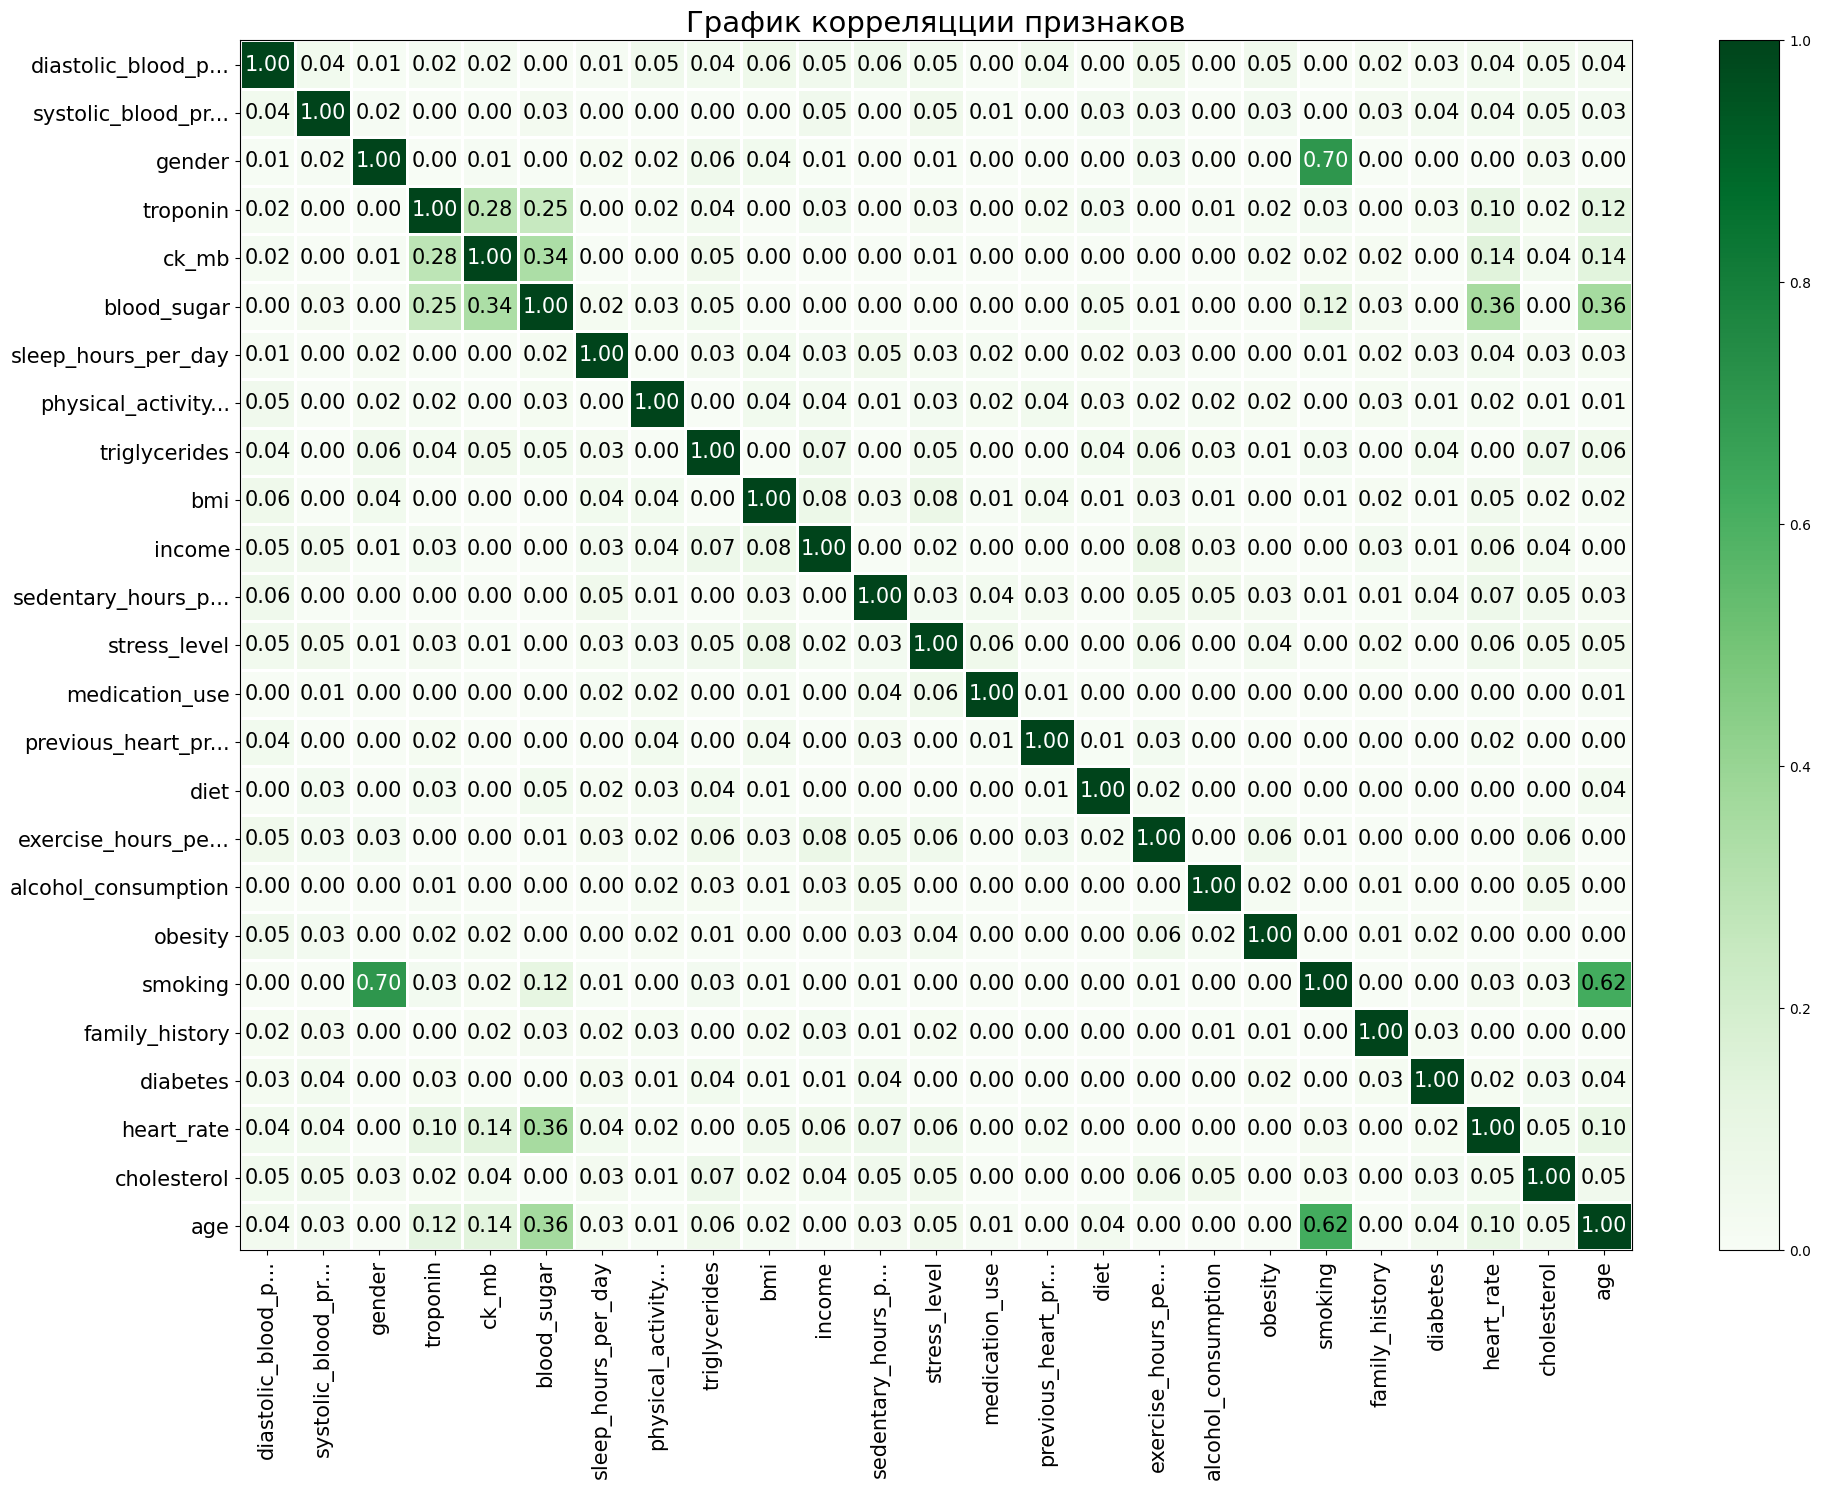

In [29]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='График корреляцции признаков',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Утечки целевого признака не обнаружено. Мультиколленеарность не выявлена. Высокий показатель имеют курение и пол, а также курение и возраст. 
Таким образом, мы провели исследовательский анализ данных, посмотрели распределение данных во всех таблицах, по итогам анализа можно сказать, что данные выглядят достоверно, особых выбросов нет, при проведении корреляционного анализа утечки целевого признака не обнаружено.

### Подготовка данных перед обучением

In [30]:
# Обозначаем параметры
ohe_columns = [
    'diet',
    'gender'
]

ord_columns = [
    'stress_level'
]

num_columns = [
    'age',
    'cholesterol',
    'income',
    'bmi',
    'triglycerides',
    'blood_sugar',
    'ck_mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'sleep_hours_per_day',
    'physical_activity_days_per_week',
    'heart_rate',
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'previous_heart_problems',
    'medication_use'
]

In [31]:
# Подготовка данных для обучения
X_train = heart_train.drop(['heart_attack_risk_binary', 'id'], axis=1)
y_train = heart_train['heart_attack_risk_binary']

# Подготовка тестовых данных
X_test = heart_test.drop(['id'], axis=1)

In [33]:
print(X_train.shape)
print(X_test.shape)

(8442, 25)
(935, 25)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify= y_train
)

In [35]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ohe_columns),
        ('ord', OrdinalEncoder(
                categories=[
                    [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            ),ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='drop'
)

In [36]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('model', clf)
    ]
)

In [37]:
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 15),
        'model__max_features': range(2, 15)
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(5, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
     {
        'model': [clf],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    {
        'model': [HistGradientBoostingClassifier(random_state=RANDOM_STATE)],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_iter': [100,200,300],
        'model__max_depth': range(2, 10)                  
    }
]


In [38]:
# обозначение параметров для обучения перебором
grid_search = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring= 'roc_auc',
    n_jobs=-1
)

In [39]:
# обучение модели на тренировочных данных
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['diet',
                                                                          'gender']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[[1.0,
                                                                                                     2.0,
                                                                                                     3.0,
                                                                                                     4.0,
                                                                                                     5.0,
                                                                                                     6.0,
                                                                                                     7.0,
                                                                                                     8.0,
                                                                                                     9.0,
                                                                                                     10.0]],
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=nan),
                                                                         ['stress_level']),
                                                                        ('num',
                                                                         Sta...
                         {'model': [LogisticRegression(penalty=['l1', 'l2'],
                                                       random_state=42,
                                                       solver='liblinear')],
                          'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['liblinear']},
                         {'model': [HistGradientBoostingClassifier(random_state=42)],
                          'model__learning_rate': [0.01, 0.1, 0.3],
                          'model__max_depth': range(2, 10),
                          'model__max_iter': [100, 200, 300],
                          'model__min_samples_leaf': [1, 2, 4]}],
             scoring='roc_auc')

In [40]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
# Получаем лучшую модель
best_model = grid_search.best_estimator_

print ('Метрика лучшей модели на кросс-валидации:', grid_search.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['diet', 'gender']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[[1.0,
                                                                              2.0,
                                                                              3.0,
                                                                              4.0,
                                                                              5.0,
                                                                              6.0,

In [41]:
y_pred_proba = best_model.predict_proba(heart_test.drop(['id'], axis=1))[:, 1]
y_pred_proba

array([8.32599395e-02, 6.93711678e-01, 1.28541203e-01, 1.15476581e-02,
       4.83373668e-01, 3.68141202e-01, 5.81012671e-01, 4.20465163e-02,
       8.75487766e-01, 6.04898069e-01, 1.76758324e-01, 2.23846705e-01,
       6.42426593e-01, 1.31789093e-01, 2.60247896e-01, 2.16464552e-01,
       7.55443066e-03, 1.06992197e-02, 1.33015844e-01, 2.65205122e-01,
       5.01645084e-01, 1.03506248e-01, 5.84786109e-01, 1.83420277e-01,
       5.73063133e-01, 5.44528734e-01, 1.78182919e-01, 8.04508948e-01,
       9.51900623e-01, 7.87859286e-01, 5.44476193e-01, 4.41563314e-02,
       6.29505683e-01, 6.90597601e-01, 8.80988874e-01, 1.85563312e-01,
       7.12629450e-03, 2.20096346e-01, 2.36510207e-03, 4.26250149e-02,
       9.31062642e-01, 5.20836305e-01, 4.27705567e-01, 4.00543878e-01,
       2.94013088e-01, 8.20136591e-02, 1.48715421e-01, 9.53586007e-01,
       7.17217605e-01, 3.37275784e-02, 1.21832774e-01, 2.03774539e-02,
       9.42562980e-02, 7.56025040e-03, 7.93632782e-02, 9.07483246e-01,
      

In [42]:
# Сначала делаем предсказания на валидационной выборке для оценки модели
y_pred_proba_mt = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba_mt > 0.6).astype(int)

In [43]:
# Расчет метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba_mt)

print(f'Доля правильных предсказаний {accuracy}')
print(f'Доля истинно положительных среди всех положительных предсказаний {precision}')
print(f'Доля истинно положительных среди всех реально положительных случаев {recall}')
print(f'Гармоническое среднее между precision и recall {f1}')
print(f'Площадь под ROC-кривой, показывает способность модели различать классы {roc_auc}')

Доля правильных предсказаний 0.6518650088809946
Доля истинно положительных среди всех положительных предсказаний 0.5316455696202531
Доля истинно положительных среди всех реально положительных случаев 0.208955223880597
Гармоническое среднее между precision и recall 0.3
Площадь под ROC-кривой, показывает способность модели различать классы 0.6003851216599629


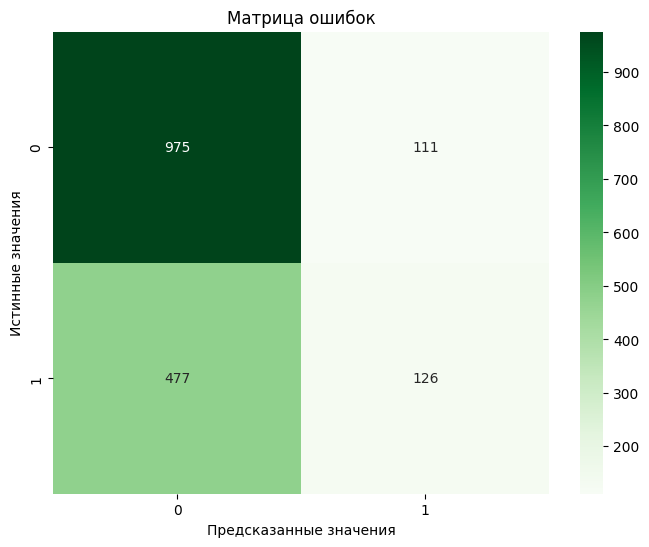

In [44]:
# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

Accuracy (0.65) <br>
Модель правильно классифицирует 65% всех случаев. <br>
Это средний результат, но для медицинской диагностики может быть недостаточно высокий. <br>

ROC-AUC (0.6) <br>
Модель недостаточно хорошо различает классы

#### Сохранение результатов

In [45]:
# Сохраняем предсказания в DataFrame
predictions = pd.DataFrame({
    'id': heart_test['id'],
    'prediction': y_pred_proba
})

In [46]:
# Сохраняем результаты в файл
predictions.to_csv('predictions.csv', index=False)

In [47]:
# Выгружаем модель для дальнейшего использования
#joblib.dump(best_model, 'model.pkl')

### Вывод о проделанной работе:

В рамках данного проекта была успешно выполнена задача по разработке модели предсказания риска сердечного приступа у пациентов:

###### 1. Подготовка и анализ данных
- Проведен детальный анализ датасета, включающий 28 признаков
- Выполнена предобработка данных, включая обработку пропущенных значений
- Проведен анализ корреляций между признаками
- Исследованы распределения числовых и категориальных признаков

###### 2. Разработка модели
- Протестированы различные алгоритмы машинного обучения:
  - Логистическая регрессия
  - Метод k-ближайших соседей
  - Дерево решений
  - Случайный лес
- Выполнена оптимизация гиперпараметров с помощью GridSearchCV
- Выбрана лучшая модель на основе метрики ROC-AUC. Она получилась равной 0.6. И модель HistGradientBoostingClassifier с параметрами max_iter=300 и min_samples_leaf=2.

###### 3. Результаты
- Модель успешно справляется с задачей классификации риска сердечного приступа
- Реализован полный пайплайн обработки данных
- Подготовлены предсказания для тестовой выборки
- Результаты сохранены в файл predictions.csv

##### Заключение
Проект успешно выполнен и может быть использован для практического применения в медицинской диагностике. Разработанная модель показывает результаты в предсказании риска сердечного приступа, что может быть полезно для профилактики и ранней диагностики сердечно-сосудистых заболеваний. 